In [32]:
!ls ../../data/clean/

afp-fact-check-clean.csv
cdc_faqs_cleaned.csv
cleaned_politifact_data.csv
cleaned_princeton_data.csv
CoAID_poynter_data_cleaned_13Jul.csv
CoAID_poynter_data_cleaned_13Jul_V2.csv
CoAID_poynter_data_cleaned_13Jul_V3.csv
CoAID_poynter_data_cleaned2.csv
CoAID_poynter_data_cleaned2.txt
CoAID_poynter_data_cleaned.csv
Collate_All_data.ipynb
Collated_data_cleaned_AJ.csv
Collated_data_cleaned_AJ_summarized_claims.csv
Collated_data_cleaned_AJ_summarized_claimsV2.csv
Collated_data.csv
Collated_data_Jul13.csv
Collated_data_x_7-19.csv
ecdc_faqs_cleaned.csv
misc_myths_cleaned_4.txt
misc_myths_cleaned.csv
poynter_data_final_ratings_13jul.csv
poynterDataScraped12Jul2020.csv
Scape_poynter.ipynb
who_myths_cleaned.csv


In [1]:
import pandas as pd
import re
import string
import bert
import tensorflow_hub as hub
import numpy as np
from sklearn.model_selection import train_test_split
import os
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
import tensorflow as tf
from tensorflow import keras as keras
import tqdm
from tensorflow.keras import layers
import pickle
import matplotlib.pyplot as plt
import requests
import json
import urllib.parse
import sys
%matplotlib inline


In [2]:
print(pd.__version__)

1.0.1


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
df = pd.read_csv('../../data/clean/Collated_data_x_7-19.csv')

In [4]:
df

,RecordNumber,claim,label,source_label,source,date,claim_source,explanation,fact_check_url,clean_claim
0,0,"In voting by mail, hundreds of thousands of ba...",false,barely-true,Politifact,2020-06-03,J. Christian Adams,NaN,https://politifact.com/factchecks/2020/jun/09/...,In voting by mail hundreds of thousands of bal...
1,1,Research illustrates a clear correlation betwe...,true,true,Politifact,2020-05-21,Glenn Grothman,NaN,https://politifact.com/factchecks/2020/jun/08/...,Research illustrates clear correlation between...
2,2,She’s just casually carrying a body with 1 han...,false,false,Politifact,2020-06-03,Viral image,NaN,https://politifact.com/factchecks/2020/jun/05/...,Shes just casually carrying body with 1 hand.....
3,3,You see suicide rates are skyrocketing now…”,false,false,Politifact,2020-05-26,Tim Murtaugh,NaN,https://politifact.com/factchecks/2020/jun/04/...,You see suicide rates are skyrocketing now
4,4,"According to the CDC, so far this year, Florid...",false,false,Politifact,2020-05-27,Facebook posts,NaN,https://politifact.com/factchecks/2020/jun/03/...,According to the CDC so far this year Florida ...
...,...,...,...,...,...,...,...,...,...,...
12134,116,Taking a sauna or hot bath can kill coronavirus,false,NaN,www.covid-19facts.com,2020-05-28,NaN,The World Health Organisation says: “Taking a ...,https://www.covid-19facts.com/?p=83981,Taking sauna or hot bath can kill coronavirus
12135,117,Airport temperature screening for arriving pas...,false,NaN,www.covid-19facts.com,2020-05-28,NaN,The European Centre for Disease Prevention and...,https://www.covid-19facts.com/?p=83757,Airport temperature screening for arriving pas...
12136,118,Mutations are making coronavirus more aggressive,false,NaN,www.covid-19facts.com,2020-05-28,NaN,The researchers themselves say that it is not ...,https://www.covid-19facts.com/?p=83749,Mutations are making coronavirus more aggressive
12137,119,Coronavirus is no worse than the flu,false,NaN,www.covid-19facts.com,2020-05-28,NaN,"Seasonal influenza, pandemic flu (such as H1N1...",https://www.covid-19facts.com/?p=83734,Coronavirus is no worse than the flu


In [5]:
def binarize_labels(label):
    if label == 'true':
        return 1
    else:
        return 0
df['binary_label'] = df['label'].apply(lambda x: binarize_labels(str(x)))

In [12]:
#create similar claims 
similar_claim1_list = []
similar_claim2_list = []
similar_claim3_list = []
similar_claim4_list = []
similar_claim5_list = []
similar_claim6_list = []
similar_claim7_list = []
similar_claim8_list = []
similar_claim9_list = []
cosine_dist_claim1_list = []
cosine_dist_claim2_list = []
cosine_dist_claim3_list = []
cosine_dist_claim4_list = []
cosine_dist_claim5_list = []
cosine_dist_claim6_list = []
cosine_dist_claim7_list = []
cosine_dist_claim8_list = []
cosine_dist_claim9_list = []



for i,row in df.iterrows():
    try:
        payload = {'claim': urllib.parse.quote(row['clean_claim'])}
        r = requests.get('https://88rrgid4rl.execute-api.us-west-2.amazonaws.com/similar-claims?claim='\
                         +urllib.parse.quote(row['clean_claim'])
                        )
        results = json.loads(r.text)
        if results.get('claim') is not None:
            similar_claim1_list.append(results.get("similar_claims")[1]['clean_claim'])
            similar_claim2_list.append(results.get("similar_claims")[2]['clean_claim'])
            similar_claim3_list.append(results.get("similar_claims")[3]['clean_claim'])
            similar_claim4_list.append(results.get("similar_claims")[4]['clean_claim'])
            similar_claim5_list.append(results.get("similar_claims")[5]['clean_claim'])
            similar_claim6_list.append(results.get("similar_claims")[6]['clean_claim'])
            similar_claim7_list.append(results.get("similar_claims")[7]['clean_claim'])
            similar_claim8_list.append(results.get("similar_claims")[8]['clean_claim'])
            similar_claim9_list.append(results.get("similar_claims")[9]['clean_claim'])
            cosine_dist_claim1_list.append(results.get("similar_claims")[1]['cosine_dist'])
            cosine_dist_claim2_list.append(results.get("similar_claims")[2]['cosine_dist'])
            cosine_dist_claim3_list.append(results.get("similar_claims")[3]['cosine_dist'])
            cosine_dist_claim4_list.append(results.get("similar_claims")[4]['cosine_dist'])
            cosine_dist_claim5_list.append(results.get("similar_claims")[5]['cosine_dist'])
            cosine_dist_claim6_list.append(results.get("similar_claims")[6]['cosine_dist'])
            cosine_dist_claim7_list.append(results.get("similar_claims")[7]['cosine_dist'])
            cosine_dist_claim8_list.append(results.get("similar_claims")[8]['cosine_dist'])
            cosine_dist_claim9_list.append(results.get("similar_claims")[9]['cosine_dist'])
        else:
            similar_claim1_list.append('')
            similar_claim2_list.append('')
            similar_claim3_list.append('')
            similar_claim4_list.append('')
            similar_claim5_list.append('')
            similar_claim6_list.append('')
            similar_claim7_list.append('')
            similar_claim8_list.append('')
            similar_claim9_list.append('')
            cosine_dist_claim1_list.append('')
            cosine_dist_claim2_list.append('')
            cosine_dist_claim3_list.append('')
            cosine_dist_claim4_list.append('')
            cosine_dist_claim5_list.append('')
            cosine_dist_claim6_list.append('')
            cosine_dist_claim7_list.append('')
            cosine_dist_claim8_list.append('')
            cosine_dist_claim9_list.append('')
        
    except:
        e = sys.exc_info()[0]
        print("Error: %s claim: %s" % (e,row['clean_claim']))
        similar_claim1_list.append('')
        similar_claim2_list.append('')
        similar_claim3_list.append('')
        similar_claim4_list.append('')
        similar_claim5_list.append('')
        similar_claim6_list.append('')
        similar_claim7_list.append('')
        similar_claim8_list.append('')
        similar_claim9_list.append('')
        cosine_dist_claim1_list.append('')
        cosine_dist_claim2_list.append('')
        cosine_dist_claim3_list.append('')
        cosine_dist_claim4_list.append('')
        cosine_dist_claim5_list.append('')
        cosine_dist_claim6_list.append('')
        cosine_dist_claim7_list.append('')
        cosine_dist_claim8_list.append('')
        cosine_dist_claim9_list.append('')

        
df['similar_claim1'] = similar_claim1_list
df['similar_claim2'] = similar_claim2_list
df['similar_claim3'] = similar_claim3_list
df['similar_claim4'] = similar_claim4_list
df['similar_claim5'] = similar_claim5_list
df['similar_claim6'] = similar_claim6_list
df['similar_claim7'] = similar_claim7_list
df['similar_claim8'] = similar_claim8_list
df['similar_claim9'] = similar_claim9_list
df['cosine_dist_claim1'] = cosine_dist_claim1_list
df['cosine_dist_claim2'] = cosine_dist_claim2_list
df['cosine_dist_claim3'] = cosine_dist_claim3_list
df['cosine_dist_claim4'] = cosine_dist_claim4_list
df['cosine_dist_claim5'] = cosine_dist_claim5_list
df['cosine_dist_claim6'] = cosine_dist_claim6_list
df['cosine_dist_claim7'] = cosine_dist_claim7_list
df['cosine_dist_claim8'] = cosine_dist_claim8_list
df['cosine_dist_claim9'] = cosine_dist_claim9_list
            
            

In [32]:
#create similar claims 
for i,row in df.iterrows():
    if row['similar_claim1'] == '':
        try:
            payload = {'claim': urllib.parse.quote(row['clean_claim'])}
            r = requests.get('https://88rrgid4rl.execute-api.us-west-2.amazonaws.com/similar-claims?claim='\
                             +urllib.parse.quote(row['clean_claim'])
                            )
            results = json.loads(r.text)
            if results.get('claim') is not None:
                df.at[i,'similar_claim1'] = results.get("similar_claims")[1]['clean_claim']
                df.at[i,'similar_claim2'] = results.get("similar_claims")[2]['clean_claim']
                df.at[i,'similar_claim3'] = results.get("similar_claims")[3]['clean_claim']
                df.at[i,'similar_claim4'] = results.get("similar_claims")[4]['clean_claim']
                df.at[i,'similar_claim5'] = results.get("similar_claims")[5]['clean_claim']
                df.at[i,'similar_claim6'] = results.get("similar_claims")[6]['clean_claim']
                df.at[i,'similar_claim7'] = results.get("similar_claims")[7]['clean_claim']
                df.at[i,'similar_claim8'] = results.get("similar_claims")[8]['clean_claim']
                df.at[i,'similar_claim9'] = results.get("similar_claims")[9]['clean_claim']
                
                df.at[i,'cosine_dist_claim1'] = results.get("similar_claims")[1]['cosine_dist']
                df.at[i,'cosine_dist_claim2'] = results.get("similar_claims")[2]['cosine_dist']
                df.at[i,'cosine_dist_claim3'] = results.get("similar_claims")[3]['cosine_dist']
                df.at[i,'cosine_dist_claim4'] = results.get("similar_claims")[4]['cosine_dist']
                df.at[i,'cosine_dist_claim5'] = results.get("similar_claims")[5]['cosine_dist']
                df.at[i,'cosine_dist_claim6'] = results.get("similar_claims")[6]['cosine_dist']
                df.at[i,'cosine_dist_claim7'] = results.get("similar_claims")[7]['cosine_dist']
                df.at[i,'cosine_dist_claim8'] = results.get("similar_claims")[8]['cosine_dist']
                df.at[i,'cosine_dist_claim9'] = results.get("similar_claims")[9]['cosine_dist']
                
                #similar_claim1_list.append(results.get("similar_claims")[1]['clean_claim'])
                #similar_claim2_list.append(results.get("similar_claims")[2]['clean_claim'])
                #similar_claim3_list.append(results.get("similar_claims")[3]['clean_claim'])
                #similar_claim4_list.append(results.get("similar_claims")[4]['clean_claim'])
                #similar_claim5_list.append(results.get("similar_claims")[5]['clean_claim'])
                #similar_claim6_list.append(results.get("similar_claims")[6]['clean_claim'])
                #similar_claim7_list.append(results.get("similar_claims")[7]['clean_claim'])
                #similar_claim8_list.append(results.get("similar_claims")[8]['clean_claim'])
                #similar_claim9_list.append(results.get("similar_claims")[9]['clean_claim'])
                #cosine_dist_claim1_list.append(results.get("similar_claims")[1]['cosine_dist'])
                #cosine_dist_claim2_list.append(results.get("similar_claims")[2]['cosine_dist'])
                #cosine_dist_claim3_list.append(results.get("similar_claims")[3]['cosine_dist'])
                #cosine_dist_claim4_list.append(results.get("similar_claims")[4]['cosine_dist'])
                #cosine_dist_claim5_list.append(results.get("similar_claims")[5]['cosine_dist'])
                #cosine_dist_claim6_list.append(results.get("similar_claims")[6]['cosine_dist'])
                #cosine_dist_claim7_list.append(results.get("similar_claims")[7]['cosine_dist'])
                #cosine_dist_claim8_list.append(results.get("similar_claims")[8]['cosine_dist'])
                #cosine_dist_claim9_list.append(results.get("similar_claims")[9]['cosine_dist'])
        except:
            e = sys.exc_info()[0]
            print("Error: %s claim: %s" % (e,row['clean_claim']))


In [34]:
df3 = df[df['similar_claim1']!='']

In [3]:
df = pd.read_csv('../../data/clean/Collated_data_with_similar_claimsV3.csv')

In [11]:
df1 = df[0:3000]
df2 = df[3000:6000]
df3 = df[6000:9000]
df4 = df[9000:13000]

In [12]:
df1.to_csv('../../data/clean/Collated_data_with_similar_claimsV3_Part1.csv',index=False)
df2.to_csv('../../data/clean/Collated_data_with_similar_claimsV3_Part2.csv',index=False)
df3.to_csv('../../data/clean/Collated_data_with_similar_claimsV3_Part3.csv',index=False)
df4.to_csv('../../data/clean/Collated_data_with_similar_claimsV3_Part4.csv',index=False)

In [ ]:
def preprocess_text_for_cleaned_column(sen):
    sentence = sen

    # Remove punctuations and foreign characters
    sentence = ' '.join(re.sub(r'[^A-Za-z0-9 .-]+', '', sentence).split())

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+",' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+',' ', sentence)

    return sentence

def inital_clean(s):
    sentence = s.strip()
    sentence = re.sub(r'"','', sentence)
    sentence = re.sub(r'“','', sentence)
    sentence = sentence[0].upper() + sentence[1:]

    return sentence

result['claim'] = result['claim'].apply(inital_clean)
result['clean_claim'] = result['claim'].apply(lambda x: preprocess_text(str(x)))

In [4]:
df.head()

,RecordNumber,claim,label,source_label,source,date,claim_source,explanation,fact_check_url,clean_claim,...,similar_claim9,cosine_dist_claim1,cosine_dist_claim2,cosine_dist_claim3,cosine_dist_claim4,cosine_dist_claim5,cosine_dist_claim6,cosine_dist_claim7,cosine_dist_claim8,cosine_dist_claim9
0,0,"In voting by mail, hundreds of thousands of ba...",false,barely-true,Politifact,2020-06-03,J. Christian Adams,NaN,https://politifact.com/factchecks/2020/jun/09/...,In voting by mail hundreds of thousands of bal...,...,The US presidential election is canceled due t...,0.602226,0.637700,0.646381,0.659291,0.659843,0.662676,0.669480,0.671890,0.672556
1,1,Research illustrates a clear correlation betwe...,true,true,Politifact,2020-05-21,Glenn Grothman,NaN,https://politifact.com/factchecks/2020/jun/08/...,Research illustrates clear correlation between...,...,This graph compares coronavirus deaths with ot...,0.557431,0.562402,0.582647,0.587008,0.588801,0.591309,0.594072,0.595554,0.595790
2,2,She’s just casually carrying a body with 1 han...,false,false,Politifact,2020-06-03,Viral image,NaN,https://politifact.com/factchecks/2020/jun/05/...,Shes just casually carrying body with 1 hand.....,...,Unverified false news at a time when Nepal had...,0.435398,0.519746,0.582629,0.588759,0.606410,0.611016,0.622001,0.629909,0.654679
3,3,You see suicide rates are skyrocketing now…”,false,false,Politifact,2020-05-26,Tim Murtaugh,NaN,https://politifact.com/factchecks/2020/jun/04/...,You see suicide rates are skyrocketing now,...,In Chicago Covid19 actually LOWERED the death ...,0.557602,0.580023,0.607595,0.619634,0.620082,0.629805,0.630297,0.635777,0.635777
4,4,"According to the CDC, so far this year, Florid...",false,false,Politifact,2020-05-27,Facebook posts,NaN,https://politifact.com/factchecks/2020/jun/03/...,According to the CDC so far this year Florida ...,...,Weve still had more deaths to the flu this yea...,0.358684,0.382999,0.405241,0.426793,0.432481,0.447899,0.455601,0.457397,0.460139


In [4]:
total = df['binary_label'].count()
true_claim_count =  df['binary_label'][df['binary_label'] == 1].count()
false_claim_count =  df['binary_label'][df['binary_label'] == 0].count()

In [5]:
print("Total Claim:",total)
print("True Claims:",true_claim_count)
print("False Claims:",false_claim_count)
print("false claim percentage",false_claim_count/total)

Total Claim: 12137
True Claims: 1764
False Claims: 10373
false claim percentage 0.8546593062536046


In [4]:
#create data set with two columns clean_claim and label 
df_data = pd.DataFrame()
df_data['clean_claim'] = df['clean_claim']
df_data['label'] = df['label']
df_data['binary_label'] = df['binary_label']
df_data['similar_claim1'] = df['similar_claim1']
df_data['similar_claim2'] = df['similar_claim2']
df_data['similar_claim3'] = df['similar_claim3']
df_data['similar_claim4'] = df['similar_claim4']
df_data['similar_claim5'] = df['similar_claim5']
df_data['similar_claim6'] = df['similar_claim6']
df_data['similar_claim7'] = df['similar_claim7']
df_data['similar_claim8'] = df['similar_claim8']
df_data['similar_claim9'] = df['similar_claim9']
#create train,test and validation set 
train_data,test_data  = train_test_split(df_data,test_size=0.1,random_state=42)
train_data,val_data = train_test_split(train_data,test_size=0.1,random_state=42)


In [ ]:
### CNN MODEL START

In [5]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [6]:
class ClaimDetectionBertEncoder:
    DATA_COLUMN = "clean_claim"
    LABEL_COLUMN = "binary_label"
    def __init__(self,train,test,tokenizer,max_seq_len=202):
        
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        ((self.train_x, self.train_y,self.train_masks,self.train_segments),\
         (self.test_x, self.test_y,self.test_masks,self.test_segments)) =\
         map(self._prepare, [train, test])
 
    
    def _prepare(self, df):
        x,y,masks,segments = [], [],[],[]
        for _, row in df.iterrows():
            
            text, label =\
            row[ClaimDetectionBertEncoder.DATA_COLUMN], \
            row[ClaimDetectionBertEncoder.LABEL_COLUMN]
            similar_claim1 = row['similar_claim1']
            similar_claim2 = row['similar_claim2']
            similar_claim3 = row['similar_claim3']
            similar_claim4 = row['similar_claim4']
            similar_claim5 = row['similar_claim5']
            similar_claim6 = row['similar_claim6']
            similar_claim7 = row['similar_claim7']
            similar_claim8 = row['similar_claim8']
            similar_claim9 = row['similar_claim9']
            
            
            text = self.tokenizer.tokenize(text)
            similar_claim1 = self.tokenizer.tokenize(similar_claim1)
            similar_claim2 = self.tokenizer.tokenize(similar_claim2)
            similar_claim3 = self.tokenizer.tokenize(similar_claim3)
            similar_claim4 = self.tokenizer.tokenize(similar_claim4)
            similar_claim5 = self.tokenizer.tokenize(similar_claim5)
            similar_claim6 = self.tokenizer.tokenize(similar_claim6)
            similar_claim7 = self.tokenizer.tokenize(similar_claim7)
            similar_claim8 = self.tokenizer.tokenize(similar_claim8)
            similar_claim9 = self.tokenizer.tokenize(similar_claim9)
            
            text = text[:20]
            similar_claim1 = similar_claim1[:20]
            similar_claim2 = similar_claim2[:20]
            similar_claim3 = similar_claim3[:20]
            similar_claim4 = similar_claim4[:20]
            similar_claim5 = similar_claim5[:20]
            similar_claim6 = similar_claim6[:20]
            similar_claim7 = similar_claim7[:20]
            similar_claim8 = similar_claim8[:20]
            similar_claim9 = similar_claim9[:20]
            input_sequence = ["[CLS]"] +\
                             text +\
                             similar_claim1 +\
                             similar_claim2 +\
                             similar_claim3 +\
                             similar_claim4 +\
                             similar_claim5 +\
                             similar_claim6 +\
                             similar_claim7 +\
                             similar_claim8 +\
                             similar_claim9 +\
                             ["[SEP]"]
            pad_len = self.max_seq_len - len(input_sequence)
        
            tokens = tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0] * pad_len
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * self.max_seq_len
        
            x.append(tokens)
            masks.append(pad_masks)
            segments.append(segment_ids)
            y.append(label)
        return np.array(x), np.array(y),np.array(masks),np.array(segments)

    

In [7]:
def flatten_layers(root_layer):
    if isinstance(root_layer, keras.layers.Layer):
        yield root_layer
    for layer in root_layer._layers:
        for sub_layer in flatten_layers(layer):
            yield sub_layer
            
def create_model2(max_seq_len,cnn_filters,dropout_rate,dnn_units):
    input_ids = keras.layers.Input(
                                   shape=(max_seq_len, ),
                                   dtype='int32',
                                   name="input_ids"
                                   )
    input_mask = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_mask")
    segment_ids = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="segment_ids")
    
    _, bert_output = bert_layer([input_ids, input_mask, segment_ids])
    #for layer in flatten_layers(bert_layer):
    #    if layer.name in ["LayerNorm", "adapter-down", "adapter-up"]:
    #        layer.trainable = True
    #    elif len(layer._layers) == 0:
    #        layer.trainable = False
        #bert_layer.embeddings_layer.trainable = False
    #print("bert shape", bert_output.shape)
    #bert_output = bert_layer(input_ids)
    print("bert shape", bert_output.shape)
    
    
    cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")(bert_output)
    cnn_layer1 = layers.GlobalMaxPool1D()(cnn_layer1)
    cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")(bert_output)
    cnn_layer2 = layers.GlobalMaxPool1D()(cnn_layer2)
    cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")(bert_output)
    cnn_layer3 = layers.GlobalMaxPool1D()(cnn_layer3)

    concatenated = tf.concat([cnn_layer1, cnn_layer2, cnn_layer3], axis=-1) # (batch_size, 3 * cnn_filters)   
    dense_1 = layers.Dense(units=dnn_units, activation="relu")(concatenated)
    dropout = layers.Dropout(rate=dropout_rate)(concatenated)
       
    last_dense = layers.Dense(units=1,activation="sigmoid")(dropout)
    
    model = keras.Model(inputs=[input_ids,input_mask,segment_ids], outputs=last_dense)
    
    #cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    #cls_out = keras.layers.Dropout(0.5)(cls_out)
    #logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    #logits = keras.layers.Dropout(0.5)(logits)
    #logits = keras.layers.Dense(
    #units=len(classes),
    #activation="softmax"
    #)(logits)
    #model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))
    #load_stock_weights(bert, bert_ckpt_file)
    return model

In [8]:
data = ClaimDetectionBertEncoder(
                          train_data,
                          test_data,
                          tokenizer,
                          max_seq_len=202
                          )
Experiment_Dic = { 'Experiment1': {'CNN_FILTERS':100,
                                   'DROPOUT_RATE':0.2,
                                   'DNN_UNITS':256},
                   'Experiment2':{'CNN_FILTERS':150,
                                   'DROPOUT_RATE':0.3,
                                   'DNN_UNITS':512},
                   'Experiment3':{'CNN_FILTERS':200,
                                   'DROPOUT_RATE':0.1,
                                   'DNN_UNITS':128},
                   'Experiment4':{'CNN_FILTERS':250,
                                   'DROPOUT_RATE':0.4,
                                   'DNN_UNITS':512}
}


precision_obj = tf.keras.metrics.Precision()
recall_obj = tf.keras.metrics.Recall()

In [11]:
from sklearn.utils import class_weight
def run_experiments2(Experiment_No):
    ExperimentNo = 'Experiment'+str(Experiment_No)
    print("Running ",ExperimentNo)
    CNN_FILTERS = Experiment_Dic[ExperimentNo]['CNN_FILTERS']
    DROPOUT_RATE = Experiment_Dic[ExperimentNo]['DROPOUT_RATE']
    DNN_UNITS = Experiment_Dic[ExperimentNo]['DNN_UNITS']
    model = create_model2(data.max_seq_len,CNN_FILTERS,DROPOUT_RATE,DNN_UNITS)
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(data.train_y[0:2048]),
                                                 data.train_y[0:2048])
    class_weights = dict(enumerate(class_weights))
    
    model.compile(
                   optimizer=keras.optimizers.Adam(1e-5),
                   loss='binary_crossentropy',
                   metrics=['accuracy',precision_obj,recall_obj]
                 )
    history = model.fit(
                        x=[data.train_x[0:2048],data.train_masks[0:2048],data.train_segments[0:2048]],
                        y=data.train_y[0:2048],
                        validation_split=0.1,
                        class_weight=class_weights,
                        batch_size=8,
                        shuffle=True,
                        epochs=20)
    with open(ExperimentNo+'CNN_BERT_SIMILAR_TRAINABLE_V2_history2', 'wb') as file_history:
        pickle.dump(history.history, file_history)

In [ ]:
for i in range(1,5):
    run_experiments2(i)

Running  Experiment1
bert shape (None, None, 768)
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train on 1843 samples, validate on 205 samples
Epoch 1/20
 888/1843 [=============>................] - ETA: 18:30 - loss: 0.6483 - accuracy: 0.6678 - precision: 0.2616 - recall: 0.6870

In [39]:
def plot_experiments2(ExperimentNumber):
    ExperimentNo = "Experiment"+str(ExperimentNumber)
    if ( os.path.exists(ExperimentNo+'CNN_BERT_SIMILAR_TRAINABLE_V2_history2')) :
        
        with open(ExperimentNo+'CNN_BERT_SIMILAR_TRAINABLE_V2_history2', 'rb') as file_history:
            history = pickle.load( file_history )

        fig, axs = plt.subplots(2, 2,figsize=(15,15))
        fig.suptitle('++++++++++++++++++++++++'+ExperimentNo+'++++++++++++++++++++++',fontsize=14)
        # Plot training & validation accuracy values
        axs[0, 0].plot(history['accuracy'])
        axs[0, 0].plot(history['val_accuracy'])
        axs[0, 0].set_title(ExperimentNo+' Model accuracy')
        axs[0, 0].set_ylabel('Accuracy')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

        # Plot training & validation loss values
        axs[0, 1].plot(history['loss'])
        axs[0, 1].plot(history['val_loss'])
        axs[0, 1].set_title(ExperimentNo+' Model loss')
        axs[0, 1].set_ylabel('Binary Entropy Loss')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].legend(['Train', 'Val'], loc='upper left')
        #plt.show()


        # Plot training & validation precision values
        axs[1, 0].plot(history['precision'])
        axs[1, 0].plot(history['val_precision'])
        axs[1, 0].set_title(ExperimentNo+' Model precision')
        axs[1, 0].set_ylabel('Precision')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

        # Plot training & validation recall values
        axs[1, 1].plot(history['recall'])
        axs[1, 1].plot(history['val_recall'])
        axs[1, 1].set_title(ExperimentNo+' Model recall')
        axs[1, 1].set_ylabel('Recall')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

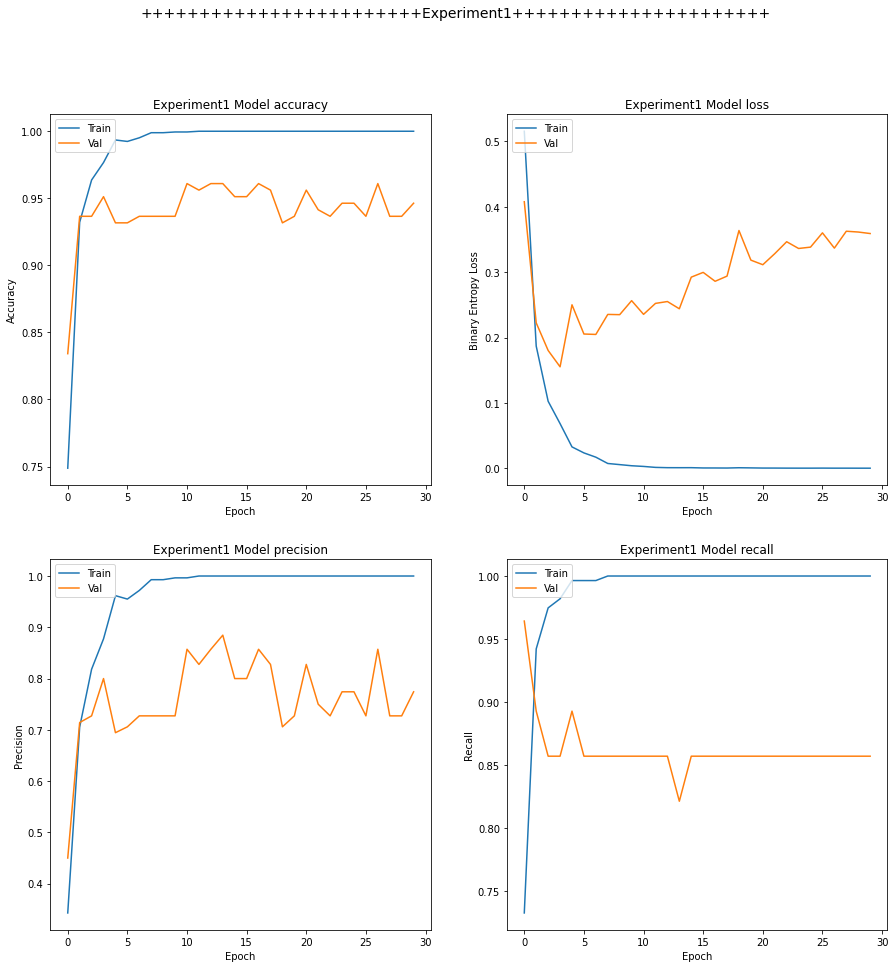

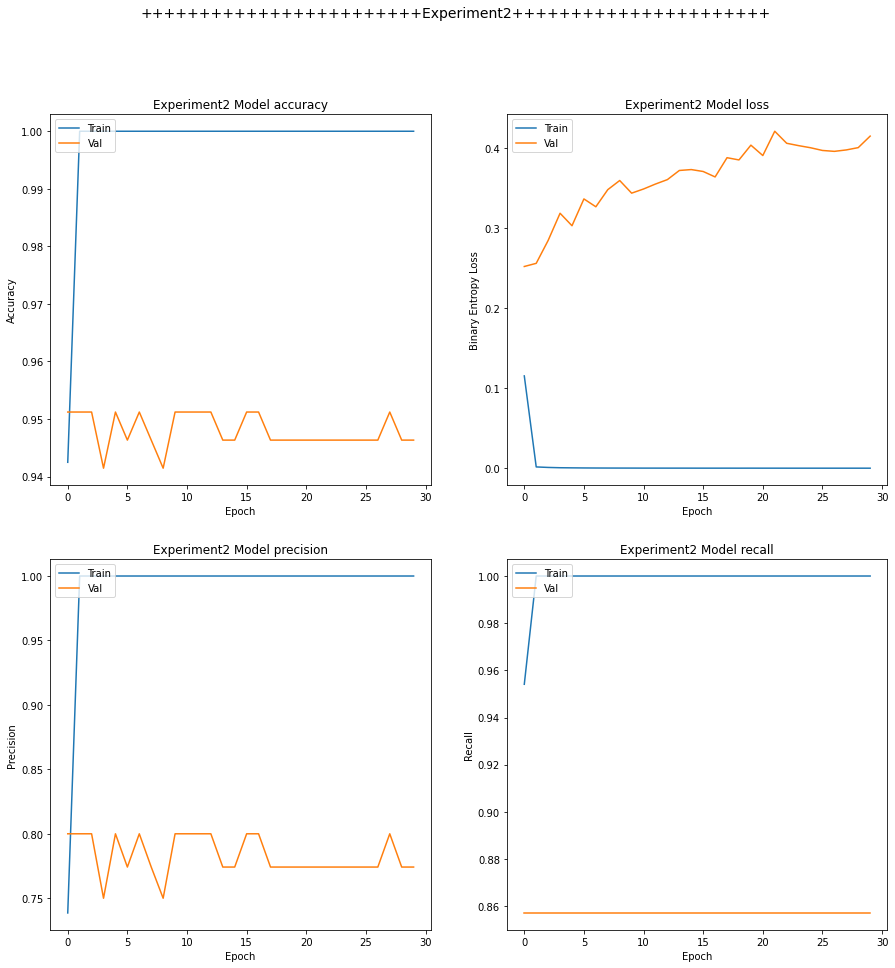

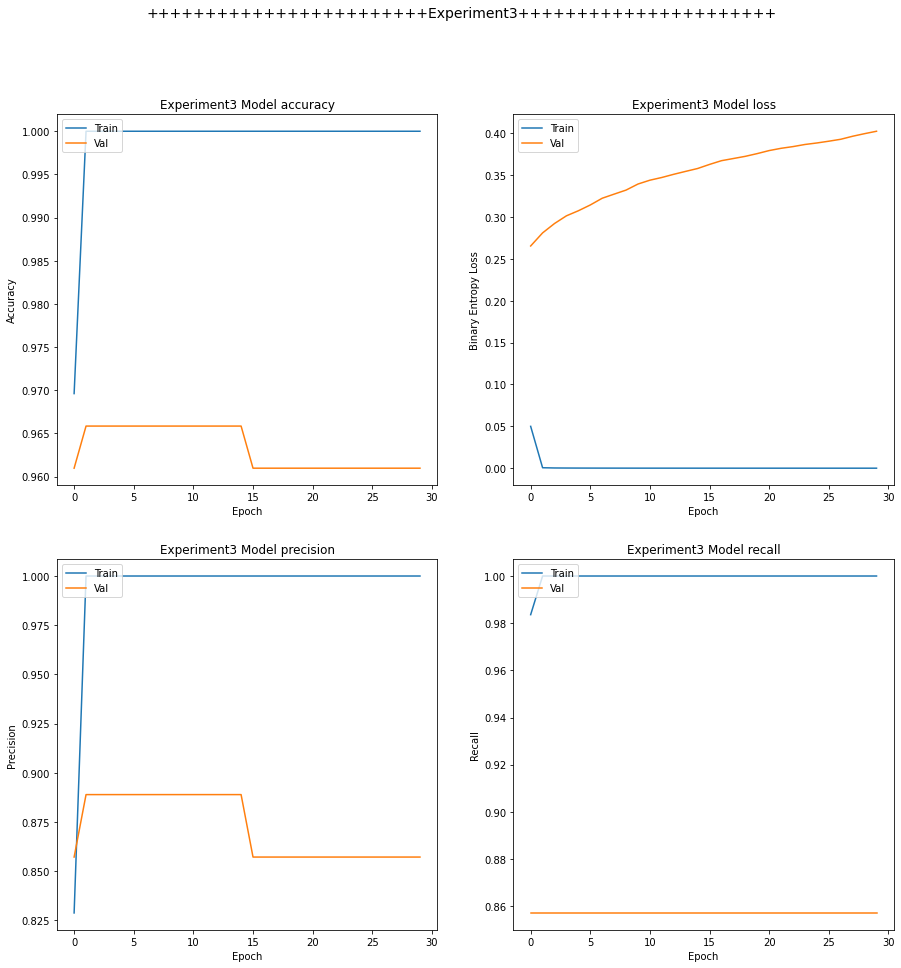

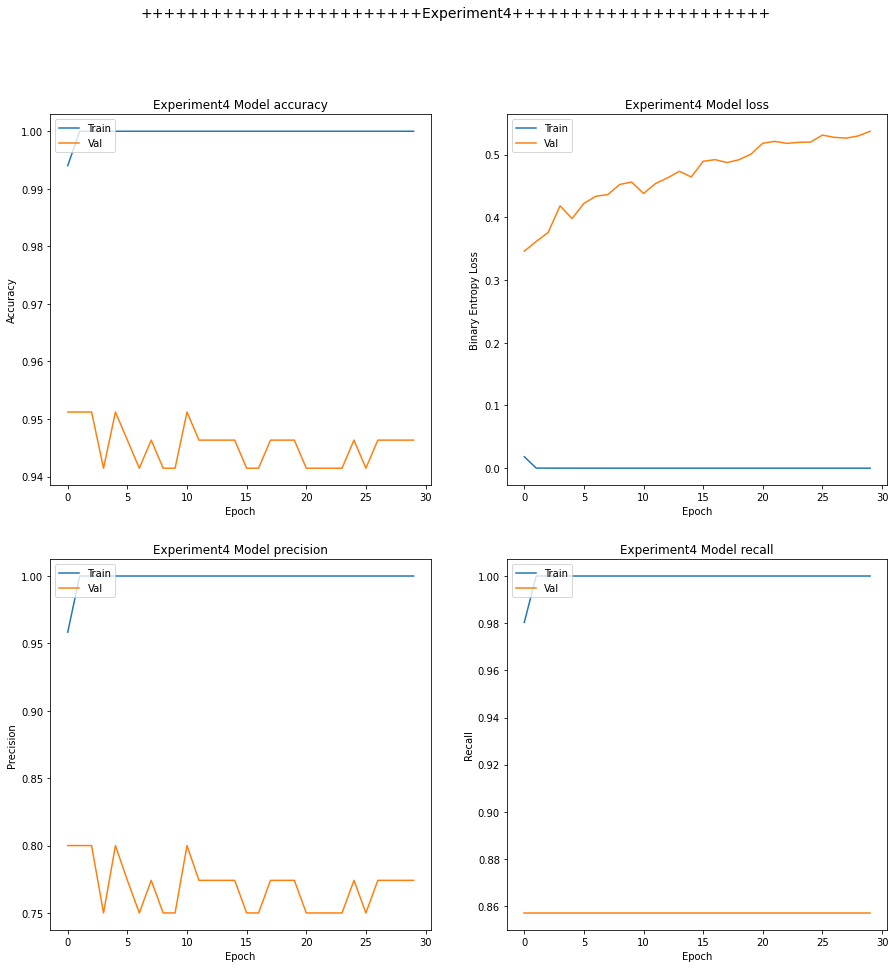

In [40]:
for i in range(1,5):
    plot_experiments2(i)

In [41]:
def find_val_acc(ExperimentNumber):
    #accuracy,loss,precision,recall = [],[],[],[]
    #val_accuracy,val_loss,val_precision,val_recall = [],[],[],[]
    ExperimentNo = "Experiment"+str(ExperimentNumber)
    if ( os.path.exists(ExperimentNo+'CNN_BERT_SIMILAR_TRAINABLE_V2_history2')) :
        
        with open(ExperimentNo+'CNN_BERT_SIMILAR_TRAINABLE_V2_history2', 'rb') as file_history:
            history = pickle.load( file_history )
        accuracy = max(history['accuracy'])
        loss = min(history['loss'])
        precision = max(history['precision'])
        recall = max(history['recall'])
        val_accuracy = max(history['val_accuracy'])
        val_loss = min(history['val_loss'])
        val_precision = max(history['val_precision'])
        val_recall= max(history['val_recall'])
        return (accuracy,loss,precision,recall, val_accuracy,val_loss,val_precision,val_recall)
def create_val_acc_matrix():
    Experiment,accuracy,loss,precision,recall = [],[],[],[],[]
    val_accuracy,val_loss,val_precision,val_recall = [],[],[],[]
    for i in range(1,5):
        accuracy_i,loss_i,precision_i,recall_i, val_accuracy_i,val_loss_i,val_precision_i,val_recall_i =\
        find_val_acc(i)
        Experiment.append(i)
        accuracy.append(accuracy_i)
        loss.append(loss_i)
        precision.append(precision_i)
        recall.append(recall_i)
        val_accuracy.append(val_accuracy_i)
        val_loss.append(val_loss_i)
        val_precision.append(val_precision_i)
        val_recall.append(val_recall_i)
    df = pd.DataFrame()
    df['Experiment'] = Experiment
    df['accuracy'] = accuracy
    df['loss'] = loss
    df['precision'] = precision
    df['recall'] = recall
    df['val_accuracy'] = val_accuracy
    df['val_loss'] = val_loss
    df['val_precision'] = val_precision
    df['val_recall'] = val_recall
    return df


val_acc_matrix = create_val_acc_matrix()

val_acc_matrix

,Experiment,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,1,1.0,0.000051,1.0,1.0,0.960976,0.155179,0.884615,0.964286
1,2,1.0,0.000018,1.0,1.0,0.951219,0.252036,0.800000,0.857143
2,3,1.0,0.000009,1.0,1.0,0.965854,0.265505,0.888889,0.857143
3,4,1.0,0.000006,1.0,1.0,0.951219,0.346114,0.800000,0.857143


In [21]:
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
def run_final_model(Experiment_No):
    ExperimentNo = 'Experiment'+str(Experiment_No)
    print("Running ",ExperimentNo)
    CNN_FILTERS = Experiment_Dic[ExperimentNo]['CNN_FILTERS']
    DROPOUT_RATE = Experiment_Dic[ExperimentNo]['DROPOUT_RATE']
    DNN_UNITS = Experiment_Dic[ExperimentNo]['DNN_UNITS']
    model = create_model2(data.max_seq_len,CNN_FILTERS,DROPOUT_RATE,DNN_UNITS)
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(data.train_y),
                                                 data.train_y)
    class_weights = dict(enumerate(class_weights))
    
    model.compile(
                   optimizer=keras.optimizers.Adam(1e-5),
                   loss='binary_crossentropy',
                   metrics=['accuracy',precision_obj,recall_obj]
                 )
    filepath="CNN_BERT_SIMILAR_TRAINABLE_V2_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
    mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_accuracy', mode='max')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

    history = model.fit(
                        x=[data.train_x,data.train_masks,data.train_segments],
                        y=data.train_y,
                        validation_split=0.1,
                        class_weight=class_weights,
                        callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
                        batch_size=8,
                        shuffle=True,
                        epochs=20)
    with open(ExperimentNo+'CNN_BERT_SIMILAR_TRAINABLE_V2_final_model_history', 'wb') as file_history:
        pickle.dump(history.history, file_history)

In [22]:
run_final_model(1)

Running  Experiment3
bert shape (None, None, 768)


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train on 7852 samples, validate on 873 samples
Epoch 1/20
7852/7852 [==============================] - 960s 122ms/sample - loss: 0.4261 - accuracy: 0.8115 - precision: 0.4360 - recall: 0.7990 - val_loss: 0.2561 - val_accuracy: 0.8740 - val_precision: 0.5413 - val_recall: 0.9219
Epoch 2/20
7852/7852 [==============================] - 925s 118ms/sample - loss: 0.2531 - accuracy: 0.9091 - precision: 0.6443 - recall: 0.9033 - val_loss: 0.2011 - val_accuracy: 0.9381 - val_precision: 0.7312 - val_recall: 0.9141
Epoch 3/20
7852/7852 [==============================] - 921s 117ms/sample - loss: 0.2059 - accuracy: 0.9255 - precision: 0.6914 - recall: 0.9249 - val_loss: 0.1808 - val_accuracy: 0.9576 - val_precision: 0.8227 - val_recall: 0.9062
Epoch 4/20
7852/7852 [==============================] - 921s 117ms/sample - loss: 0.1744 - accuracy: 0.9418 - precision: 0.7447 - recall: 0.9416 - val_loss: 0.1640 - val_accuracy: 0.9404 - val_precision: 0.7405 - val_recall: 0.9141
Epoch 5/20
7852/7852 [===

In [42]:
#Get model for Experiment1 created
CNN_FILTERS = 100
DROPOUT_RATE = 0.2
DNN_UNITS = 256
model = create_model2(202,CNN_FILTERS,DROPOUT_RATE,DNN_UNITS)
#load model weights
model.load_weights("CNN_BERT_SIMILAR_TRAINABLE_V2_weights-improvement-06-0.98.hdf5")

bert shape (None, None, 768)


In [43]:
#Evaluate Model for test data
model.compile(
                   optimizer=keras.optimizers.Adam(1e-5),
                   loss='binary_crossentropy',
                   metrics=['accuracy',precision_obj,recall_obj]
                 )
test_loss, test_acc,test_precision,test_recall = \
model.evaluate(x= [data.test_x,data.test_masks,data.test_segments], y= data.test_y)

1214/1214 [==============================] - 486s 400ms/sample - loss: 0.3293 - accuracy: 0.9432 - precision_1: 0.9008 - recall_1: 0.6566


In [44]:
#### The Code to Be Deployed #####
import pandas as pd
import re
import string
import bert
import tensorflow_hub as hub
import numpy as np
from sklearn.model_selection import train_test_split
import os
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
import tensorflow as tf
from tensorflow import keras as keras
import tqdm
from tensorflow.keras import layers
import pickle
import requests
import json
import urllib.parse
import sys
import matplotlib.pyplot as plt
%matplotlib inline

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

def create_model2(max_seq_len,cnn_filters,dropout_rate,dnn_units):
    input_ids = keras.layers.Input(
                                   shape=(max_seq_len, ),
                                   dtype='int32',
                                   name="input_ids"
                                   )
    input_mask = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_mask")
    segment_ids = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="segment_ids")
    
    _, bert_output = bert_layer([input_ids, input_mask, segment_ids])
    #bert_output = bert_layer(input_ids)
    print("bert shape", bert_output.shape)
    
    
    cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")(bert_output)
    cnn_layer1 = layers.GlobalMaxPool1D()(cnn_layer1)
    cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")(bert_output)
    cnn_layer2 = layers.GlobalMaxPool1D()(cnn_layer2)
    cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")(bert_output)
    cnn_layer3 = layers.GlobalMaxPool1D()(cnn_layer3)

    concatenated = tf.concat([cnn_layer1, cnn_layer2, cnn_layer3], axis=-1) # (batch_size, 3 * cnn_filters)   
    dense_1 = layers.Dense(units=dnn_units, activation="relu")(concatenated)
    dropout = layers.Dropout(rate=dropout_rate)(concatenated)
       
    last_dense = layers.Dense(units=1,activation="sigmoid")(dropout)
    
    model = keras.Model(inputs=[input_ids,input_mask,segment_ids], outputs=last_dense)
    
    #cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    #cls_out = keras.layers.Dropout(0.5)(cls_out)
    #logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    #logits = keras.layers.Dropout(0.5)(logits)
    #logits = keras.layers.Dense(
    #units=len(classes),
    #activation="softmax"
    #)(logits)
    #model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))
    #load_stock_weights(bert, bert_ckpt_file)
    return model

#clean the texts
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have","she's":"she is","he's":"he is"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

def preprocess_text(sen):
    #convert ’ to '
    
    sentence = sen.replace("’","'")
    
    #expand contractions 
    sentence = expand_contractions(sentence.lower())
    # Removing punctuation
    #sentence = re.sub('<[^>]+>',' ', sen)

    # Remove punctuations and numbers and foreign characters
    sentence = ' '.join(re.sub('[^A-Za-z0-9 .-]+',' ', sentence).split())

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+",' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+',' ', sentence)

    return sentence

In [45]:
precision_obj = tf.keras.metrics.Precision()
recall_obj = tf.keras.metrics.Recall()
#Get model for Experiment1 created
CNN_FILTERS = 100
DROPOUT_RATE = 0.2
DNN_UNITS = 256
model = create_model2(202,CNN_FILTERS,DROPOUT_RATE,DNN_UNITS)
#load model weights
model.load_weights("CNN_BERT_SIMILAR_TRAINABLE_V2_weights-improvement-06-0.98.hdf5")

model.compile(
                   optimizer=keras.optimizers.Adam(1e-5),
                   loss='binary_crossentropy',
                   metrics=['accuracy',precision_obj,recall_obj]
                 )

def predict_claims(claim_text):
    claims = [preprocess_text(claim_text)]

    max_seq_len=202
    x_input,masks,segments = [], [],[]

    for new_claim in claims:
        
        similar_claim1 = new_claim
        similar_claim2 = new_claim
        similar_claim3 = new_claim
        similar_claim4 = new_claim
        similar_claim5 = new_claim
        similar_claim6 = new_claim
        similar_claim7 = new_claim
        similar_claim8 = new_claim
        similar_claim9 = new_claim
        try:
            payload = {'claim': urllib.parse.quote(new_claim)}
            r = requests.get('https://88rrgid4rl.execute-api.us-west-2.amazonaws.com/similar-claims?claim='\
                             +urllib.parse.quote(new_claim)
                            )
            results = json.loads(r.text) 
            if results.get('claim') is not None:
                similar_claim1 = results.get("similar_claims")[0]['clean_claim']
                similar_claim2 = results.get("similar_claims")[1]['clean_claim']
                similar_claim3 = results.get("similar_claims")[2]['clean_claim']
                similar_claim4 = results.get("similar_claims")[3]['clean_claim']
                similar_claim5 = results.get("similar_claims")[4]['clean_claim']
                similar_claim6 = results.get("similar_claims")[5]['clean_claim']
                similar_claim7 = results.get("similar_claims")[6]['clean_claim']
                similar_claim8 = results.get("similar_claims")[7]['clean_claim']
                similar_claim9 = results.get("similar_claims")[8]['clean_claim']
            else: 
                #try one more time 
                payload = {'claim': urllib.parse.quote(new_claim)}
                r = requests.get('https://88rrgid4rl.execute-api.us-west-2.amazonaws.com/similar-claims?claim='\
                             +urllib.parse.quote(new_claim)
                            )
                results = json.loads(r.text) 
                if results.get('claim') is not None:
                    similar_claim1 = results.get("similar_claims")[0]['clean_claim']
                    similar_claim2 = results.get("similar_claims")[1]['clean_claim']
                    similar_claim3 = results.get("similar_claims")[2]['clean_claim']
                    similar_claim4 = results.get("similar_claims")[3]['clean_claim']
                    similar_claim5 = results.get("similar_claims")[4]['clean_claim']
                    similar_claim6 = results.get("similar_claims")[5]['clean_claim']
                    similar_claim7 = results.get("similar_claims")[6]['clean_claim']
                    similar_claim8 = results.get("similar_claims")[7]['clean_claim']
                    similar_claim9 = results.get("similar_claims")[8]['clean_claim']
        except:

            #try once more 
            try:
                payload = {'claim': urllib.parse.quote(new_claim)}
                r = requests.get('https://88rrgid4rl.execute-api.us-west-2.amazonaws.com/similar-claims?claim='\
                                 +urllib.parse.quote(new_claim)
                                )
                results = json.loads(r.text) 
                if results.get('claim') is not None:
                    similar_claim1 = results.get("similar_claims")[0]['clean_claim']
                    similar_claim2 = results.get("similar_claims")[1]['clean_claim']
                    similar_claim3 = results.get("similar_claims")[2]['clean_claim']
                    similar_claim4 = results.get("similar_claims")[3]['clean_claim']
                    similar_claim5 = results.get("similar_claims")[4]['clean_claim']
                    similar_claim6 = results.get("similar_claims")[5]['clean_claim']
                    similar_claim7 = results.get("similar_claims")[6]['clean_claim']
                    similar_claim8 = results.get("similar_claims")[7]['clean_claim']
                    similar_claim9 = results.get("similar_claims")[8]['clean_claim']
            except:

                 e = sys.exc_info()[0]

        
        text = tokenizer.tokenize(new_claim)

        similar_claim1 = tokenizer.tokenize(similar_claim1)
        similar_claim2 = tokenizer.tokenize(similar_claim2)
        similar_claim3 = tokenizer.tokenize(similar_claim3)
        similar_claim4 = tokenizer.tokenize(similar_claim4)
        similar_claim5 = tokenizer.tokenize(similar_claim5)
        similar_claim6 = tokenizer.tokenize(similar_claim6)
        similar_claim7 = tokenizer.tokenize(similar_claim7)
        similar_claim8 = tokenizer.tokenize(similar_claim8)
        similar_claim9 = tokenizer.tokenize(similar_claim9)

        text = text[:20]
        similar_claim1 = similar_claim1[:20]
        similar_claim2 = similar_claim2[:20]
        similar_claim3 = similar_claim3[:20]
        similar_claim4 = similar_claim4[:20]
        similar_claim5 = similar_claim5[:20]
        similar_claim6 = similar_claim6[:20]
        similar_claim7 = similar_claim7[:20]
        similar_claim8 = similar_claim8[:20]
        similar_claim9 = similar_claim9[:20]
        input_sequence = ["[CLS]"] +\
                         text +\
                         similar_claim1 +\
                         similar_claim2 +\
                         similar_claim3 +\
                         similar_claim4 +\
                         similar_claim5 +\
                         similar_claim6 +\
                         similar_claim7 +\
                         similar_claim8 +\
                         similar_claim9 +\
                         ["[SEP]"]

        
        
        pad_len = max_seq_len - len(input_sequence)
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_seq_len
        x_input.append(np.array(tokens))
        masks.append(np.array(pad_masks))
        segments.append(np.array(segment_ids))

    return model.predict(x = [x_input,masks,segments])[0]

bert shape (None, None, 768)


In [46]:
predict_claims("Only certain face masks are effective and others, such as cloth masks, are not")[0]

0.0848213

In [47]:
predict_claims("Fever is a symptom of COVID-19")[0]

0.56904024

In [51]:
predict_claims("Coronavirus will die off in the summer once it gets warmer")[0]

0.00012745547

In [52]:
print(predict_claims("Washing your hands can help keep you safe from coronavirus")[0])
print(predict_claims("Hand sanitizer can't kill the virus")[0])
print(predict_claims("Children can be infected with COVID-19")[0])
print(predict_claims("Fever is a symptom of COVID-19")[0])
print(predict_claims("A positive antibody test means you can't get coronavirus again")[0])
print(predict_claims("N-95 masks work better than cloth masks")[0])
print(predict_claims("I can still get coronavirus from somebody if they are wearing a mask")[0])
print(predict_claims("Playing basketball is has a higher risk than playing tennis")[0])

0.99617755


0.0002991451


0.0009537248


0.56904024


0.0011518208


0.99577254


0.00017788213


0.0001594781
